# Zyfra Gold Recovery

# Introduction

The company Zyfra extracts gold concentrate from gold ore to make a profit. They would like to predict how much gold concentrate will be yielded from gold ore, optimizing their gold production. They have data collected from every stage of the gold extraction process. They have provided a training set, a test set, and a complete dataset. The complete dataset contains all of the observations, and all of the features/targets, even those calculated after extraction. The training set contains a subset of this data meant to train the prediction model. The test set, however, contains only the features that would be available to the company at the start of the extraction process, and therefore has fewer features and zero target data. This test set is important because this contains the data that the company wishes to make predictions off of.

A regression model will need to be trained to make numerical predictions. We will try out linear regression and random forest regression models. I will skip decision tree regression as random forest tends to be more accurate. The metric for success will be symmetric mean absolute error (sMAPE), based on the predicted gold recovery vs the actual gold recovery. I will use the trained models to predict rougher concentrate recovery and final concentrate recovery, calculate sMAPE for each, and combine the two scores for our final performance score. Both linear and random forest regression models are able to predict multiple targets from a single model. 

First I will explore preprocess the data, verifying that recovery was calculated correctly and comparing the training set with the test set. Missing values will need to be dealt with, and targets selected. Then I will compare the concentrations of each of the metals at different stages and figure out if there are any observations I should drop, and compare feed size distributions between the training set and test set. Finally I will train models, calculate combined sMAPE scores, and use the better-scoring model as our final model, training the model on our full training set and then finding final sMAPE on the test set. I will compare the final model to a dummy model and save the model to my machine for further use by the company.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

from joblib import dump

# Preprocessing

In [2]:
try:
    train = pd.read_csv('gold_recovery_train.csv')
except:
    train = pd.read_csv('/datasets/gold_recovery_train.csv')
    
try:    
    test = pd.read_csv('gold_recovery_test.csv')
except:
    test = pd.read_csv('/datasets/gold_recovery_test.csv')
    
try:
    full = pd.read_csv('gold_recovery_full.csv')
except:
    full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


I observe that the full and training datasets contain 87 columns while the test set contains only 53

In [7]:
full.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


## Verify recovery

$ (1)\ recovery = {C*(F-T) \over F*(C-T)} * 100\% $

In [8]:
def calc_recov(C, F, T):
    
    """
    This function calculates gold recovery.
    
    To calculate rougher recovery, this function takes three series as inputs:
    - C = rougher.output.concentrate_au
    - F = rougher.input.feed_au
    - T = rougher.output.tail_au
        and returns the percentage recovery of gold concentrate after the roughing stage.
    
    To calculate final recovery, this function takes three measurements as inputs:
    - C = final.output.concentrate_au
    - F = rougher.output.concentrate_au
    - T = final.tail_au
        and returns the percentage recovery of gold concentrate after the final purification stage.
    """
    
    recovery = (C*(F-T)) / (F*(C-T)) * 100
    
    return recovery

I want to calculate recovery for a row in the full dataset using my function to ensure that it works correctly, and that the values make sense.

In [9]:
# I need to drop nans before I can calculate mean absolute error, I'd rather make a df copy for now
train_cut = train.dropna(subset=['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', \
                                 'rougher.output.tail_au']) 

In [10]:
recov = train_cut['rougher.output.recovery']
pred_recov = calc_recov(train_cut['rougher.output.concentrate_au'], train_cut['rougher.input.feed_au'], train_cut['rougher.output.tail_au'])
mean_absolute_error(recov, pred_recov)

9.303415616264301e-15

Our recovery equation matches the recovery measurements exactly.

## Compare test set and training set

Let's check out the differences in columns between the training set and test set. The training set has more columns, so we should look at the columns that the test set is lacking.

In [11]:
test_columns = test.columns

In [12]:
drop_columns = train.drop(test_columns, axis=1)
drop_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                                16794 non-null  float64


Looks like the values missing from the test set are all outputs and calculations, which is data that would not be available at the start of extraction. This set mimics the data that Zyfra would have at the time of real-world prediction. From this list, we should choose which data we would like to predict.

## Preprocess datasets

### Training set

I will trim the training dataset down to the features and targets that I need, then drop nans at this point. I will split this table into training features and training targets. Later I will deal with the test set, dropping nans and getting targets from the full dataset. I will also need to include a list of columns containing concentration data for later, and a list of concentration columns that need dropped from the training set.

According to the company - observations in the datasets come in order of time, and adjacent observations tend to be similar. Even though I intend to train models later via cross-validation, I think it would be a good idea to shuffle the data once the rest of preprocessing is done. The linear regression shouldn't be affected, but the random forest model may be.

In [13]:
targets = ['rougher.output.recovery', 'final.output.recovery']

conc = ['final.output.concentrate_au', 'rougher.output.concentrate_au', 'rougher.input.feed_au', \
           'final.output.concentrate_ag', 'rougher.output.concentrate_ag', 'rougher.input.feed_ag', \
           'final.output.concentrate_pb', 'rougher.output.concentrate_pb', 'rougher.input.feed_pb', \
           'final.output.concentrate_sol', 'rougher.output.concentrate_sol', 'rougher.input.feed_sol']

conc_drop = ['final.output.concentrate_sol', 'rougher.output.concentrate_sol', \
                 'final.output.concentrate_pb', 'rougher.output.concentrate_pb', \
                 'final.output.concentrate_ag', 'rougher.output.concentrate_ag', \
                 'final.output.concentrate_au', 'rougher.output.concentrate_au']

In [14]:
drop_columns = drop_columns.drop(targets, axis=1)
drop_columns = drop_columns.drop(conc_drop, axis=1)
trim_train = train.drop(drop_columns.columns, axis=1)

In [15]:
trim_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        16860 non-null  object 
 1   final.output.concentrate_ag                 16788 non-null  float64
 2   final.output.concentrate_pb                 16788 non-null  float64
 3   final.output.concentrate_sol                16490 non-null  float64
 4   final.output.concentrate_au                 16789 non-null  float64
 5   final.output.recovery                       15339 non-null  float64
 6   primary_cleaner.input.sulfate               15553 non-null  float64
 7   primary_cleaner.input.depressant            15598 non-null  float64
 8   primary_cleaner.input.feed_size             16860 non-null  float64
 9   primary_cleaner.input.xanthate              15875 non-null  float64
 10  primary_cl

I need to remove nans so that I can run a regression model and calculate metrics. Because adjacent observations are similar to each other, I can use the preceeding values to fill the missing values with the forward fill method.

In [16]:
trim_train = trim_train.fillna(method='ffill')

Let's briefly check for duplicate observations.

In [17]:
print(trim_train.duplicated().sum())

0


No duplicates.

Let's split the training set into features and targets.

In [18]:
target_train = trim_train[targets]
features_train = trim_train.drop(targets, axis=1).drop('date', axis=1).drop(conc_drop, axis=1)

final_conc = trim_train[conc]

In [19]:
features_train

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,-401.195834,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,-399.988275,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,-399.521344,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Let's shuffle this data, using the same random state for each.

In [20]:
target_train = target_train.sample(frac=1, random_state=0)
features_train = features_train.sample(frac=1, random_state=0)

conc_train = final_conc.sample(frac=1, random_state=0)

In [21]:
target_train.head(2)

,rougher.output.recovery,final.output.recovery
15595,89.846488,75.526628
12938,94.292663,74.362554


In [22]:
features_train.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
15595,122.832333,7.579891,6.443333,1.092322,1701.492510,-498.930432,1701.369266,-500.183981,1701.354687,-497.333750,...,30.012261,-499.671008,22.927886,-499.549444,20.000769,-500.205475,15.008221,-499.925765,17.983455,-500.086309
12938,179.731047,15.991746,6.820000,1.335643,1699.905644,-498.572482,1695.083511,-499.922241,1701.312252,-498.877403,...,23.005597,-500.295804,14.897285,-500.119256,17.954706,-499.866248,11.979044,-500.227535,11.973012,-499.382210


In [23]:
conc_train.head(2)

,final.output.concentrate_au,rougher.output.concentrate_au,rougher.input.feed_au,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_pb,rougher.output.concentrate_pb,rougher.input.feed_pb,final.output.concentrate_sol,rougher.output.concentrate_sol,rougher.input.feed_sol
15595,46.381322,17.407358,6.622279,4.151463,11.869672,6.916367,10.744395,10.094682,3.717486,6.780448,29.064798,40.038658
12938,42.143984,8.025801,11.806550,6.209688,5.479148,12.905219,10.953795,3.734205,6.095087,10.666312,11.960304,37.987529


Done. Indexes match positions.

Some groups of features share scales - others do not. Concentrations of materials are on vastly different scales than air volume and fluid levels. Some standardization may be needed. I am going to run my models without standardizing and, if needed, return later to try my models with standardizing. The linear regression model may benefit, but the random forest regression model would not.

### Collect targets for test set

I will perform similar preprocessing on the test set, making similar decisions, as I did for the training set.

The test set does not come with target values, as the test set represents the data that will be available to the company before the extraction process. I want to be able to test the performance of the models by having a target available to me for comparison, if possible. I will create an extra dataset that contains the full data for the test observations, then I can collect the target values into a series for later comparison with the predictions.

In [24]:
print(test.date.duplicated().sum())
print(full.date.duplicated().sum())

0
0


The dates are unique for the test and the full datasets.

In [25]:
test_full = full[full.date.isin(test.date)]
test_full_trimmed = test_full.fillna(method='ffill')

Let's split this dataframe into features and targets.

In [26]:
features_test = test_full_trimmed.drop('date', axis=1).drop(drop_columns.columns, axis=1).drop(targets, axis=1).drop(conc_drop, axis=1).reset_index(drop=True)
target_test = test_full_trimmed[targets].reset_index(drop=True)

conc_test = test_full_trimmed[conc].reset_index(drop=True)

In [27]:
features_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


Let's again shuffle the observations.

In [28]:
features_test = features_test.sample(frac=1, random_state=0)
target_test = target_test.sample(frac=1, random_state=0)

conc_test = conc_test.sample(frac=1, random_state=0)

In [29]:
features_test.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4031,213.043191,6.490066,6.65,2.391526,1502.139909,-499.100848,1502.129624,-488.368088,1496.555007,-506.723378,...,17.994600,-499.358412,16.006259,-399.352233,12.955698,-499.834036,9.945527,-499.959387,13.986509,-499.566150
1790,221.732738,8.684621,7.16,0.945199,1596.039863,-500.679427,1601.048421,-500.211949,1598.080722,-509.774330,...,15.971493,-501.032805,13.984239,-502.369591,14.882311,-501.346112,14.022224,-500.334287,22.003192,-503.541797


In [30]:
target_test.head(2)

,rougher.output.recovery,final.output.recovery
4031,88.072093,64.915883
1790,88.831665,68.178405


In [31]:
conc_test.head(2)

,final.output.concentrate_au,rougher.output.concentrate_au,rougher.input.feed_au,final.output.concentrate_ag,rougher.output.concentrate_ag,rougher.input.feed_ag,final.output.concentrate_pb,rougher.output.concentrate_pb,rougher.input.feed_pb,final.output.concentrate_sol,rougher.output.concentrate_sol,rougher.input.feed_sol
4031,45.718941,19.005760,7.504443,4.494467,11.432113,6.753147,10.835033,8.504521,3.435767,8.948104,31.654671,46.005772
1790,48.785532,20.990325,9.548833,3.641227,12.273978,9.285046,8.652598,7.361151,3.752739,10.491327,27.124606,39.443913


I have visually verified that the features and the targets match indexes.

# Analyze Data

## Check concentrations of metals

Let's see how the concentrations of the metals vary with stage of extraction. I will use the full dataset for this. I predict that the concentration of gold will increase, while the concentrations of silver and lead will decrease.

In [32]:
def metals_eda(metal):
    
    """
    This function takes a string as input that represents the metal I wish to evaluate concentration distributions for. 
    
    For each metal I want to look at both the distributions for concentrations for the concentrates and the tails, 
        in the form of boxplots ordered from raw feed to final stage. 
    """
    
    conc_cols = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', \
                 'final.output.concentrate_']
    conc_cols = [column + metal for column in conc_cols]
    
    tail_cols = ['rougher.input.feed_', 'rougher.output.tail_', 'primary_cleaner.output.tail_', \
                 'secondary_cleaner.output.tail_', 'final.output.tail_']
    tail_cols = [column + metal for column in tail_cols]
    
    plt.figure(figsize=(14,4))
    sns.boxplot(data=full[conc_cols])
    plt.title(f"Concentration of concentrate at each stage for {metal.capitalize()}")
    
    plt.figure(figsize=(14,4))
    sns.boxplot(data=full[tail_cols])
    plt.title(f"Concentration of tail at each stage for {metal.capitalize()}")

Let's check gold first (Au).

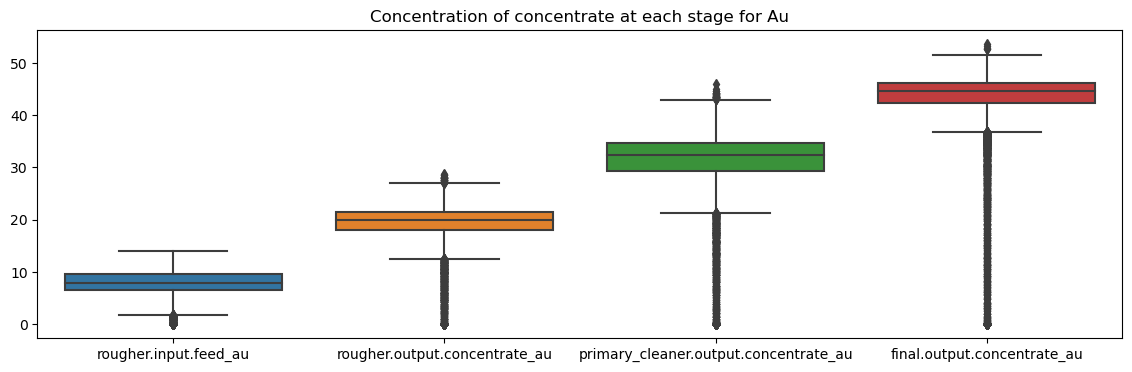

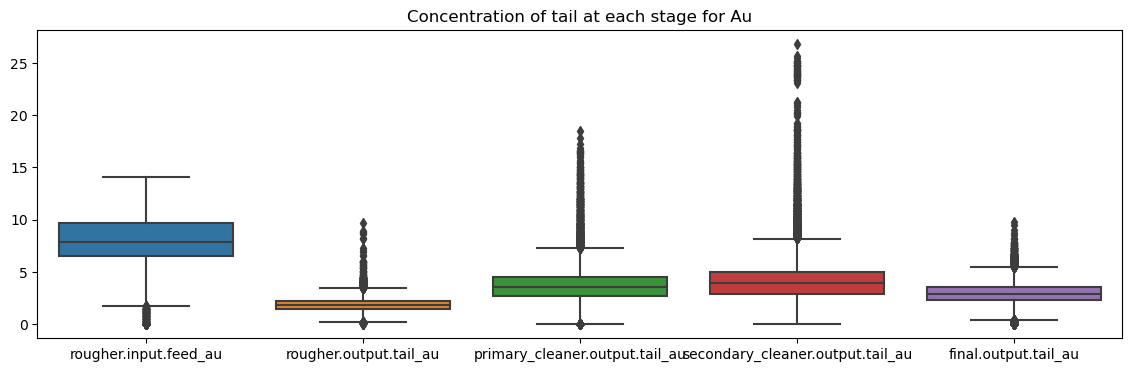

In [33]:
metals_eda('au')

Excellent - as expected, the concentration of gold concentrate increases through the stages of the extraction process. The concentration of gold in the tails stays fairly low throughout the process, which is good, because ideally, there would be zero gold in the tails for the gold extraction process. The concentration of gold starts at around 10 and finishes at nearly 50 by the end of the process. There seem to be a number of outliers where final gold concentration is low in concentrate but high in the tails, which is far from ideal.

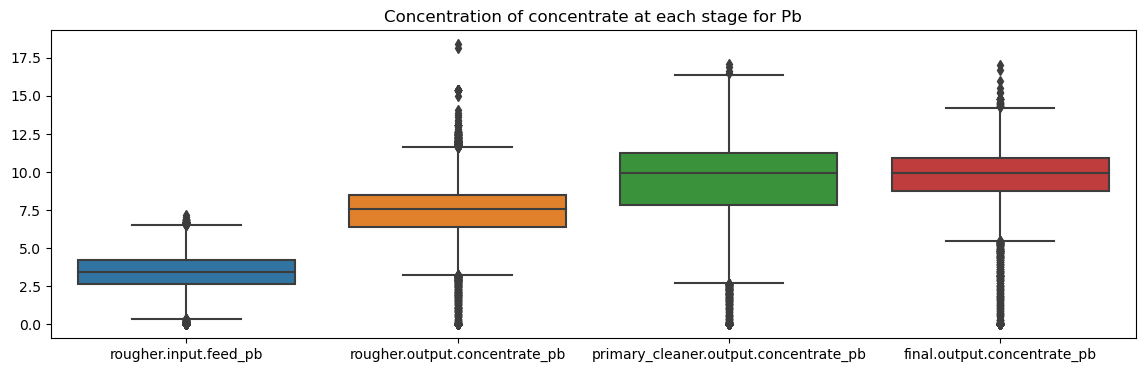

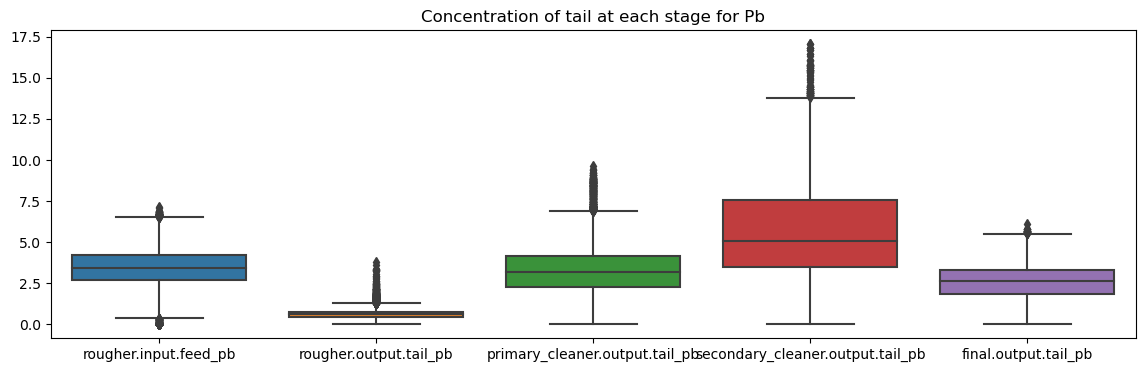

In [34]:
metals_eda('pb')

The concentration of lead starts low at around 3 but rises to around 10 by the end, which is still much less than the gold. The tail concentration fluctuates a bit but stays in the same general range throughout the process. 

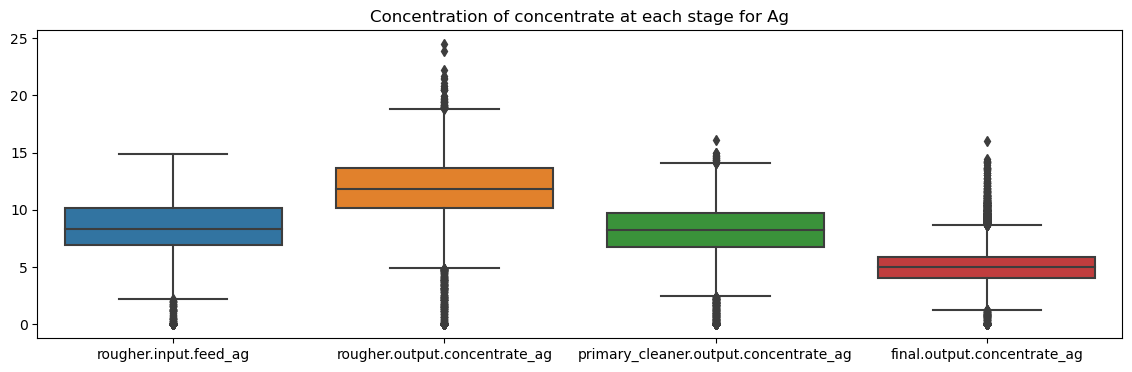

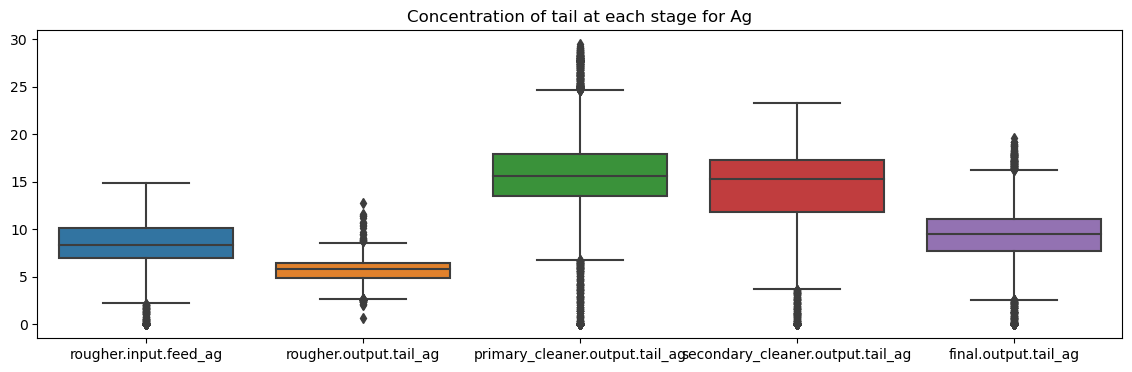

In [35]:
metals_eda('ag')

Silver concentration in the concentrate rises after the rougher stage but ultimately is lower than its starting concentration by the end of the process. There is a fairly high concentration of silver in the tails at each stage. The purification process seems to do a better job at reducing the concentration of silver than it does lead.

## Remove flawed observations

Looking at the boxplots from earlier, I notice that a number of final gold concentrations are very low. These may be normal observations if the final concentrations are at least greater than the original input concentration - but, I want to see what happens to the length of the training and test datasets if I remove observations where the final concentration of gold is lower than or equal to the concentration of gold in the input feed, as this should not happen in a gold extraction process. This relationship should be extremely uncommon. Below I will write a function that will allow me to compare these values and edit the dataframes, along with allowing me to compare any other values I wish.

In [36]:
def trim_rows(features_df, target_df, conc_df, features_col=0, target_col=0, condition='greater', indexes=0):
    
    """
    This function trims rows from a set of three dataframes (training or testing sets, plus concentrations set) based on 
        a certain measurement from one dataframe being greater or less than the other. 
    
    Takes each of the two dataframes as input, then the concentrations dataframe, then the columns that I wish to compare. 
        The "greater" toggle is set to True but can be set to False to change the direction of the comparison.
    
    The function prints the original length and the new length, and returns the three dataframes as a tuple.
    """
    
    print("Length of original dataframes:", features_df.shape[0])
    
    if condition == 'greater':
        bad_rows = features_df[features_df[features_col] >= conc_df[target_col]].index
    elif condition == 'less':
        bad_rows = features_df[features_df[features_col] <= conc_df[target_col]].index
    else:
        bad_rows = indexes

    features_df = features_df.drop(bad_rows, errors='ignore')
    target_df = target_df.drop(bad_rows, errors='ignore')
    conc_df = conc_df.drop(bad_rows, errors='ignore')
     
    print("Length of trimmed dataframes:", features_df.shape[0])
    
    return features_df, target_df, conc_df

Let's first trim down the training set, removing observations where the concentration of gold at any of the advanced stages is the same as or less than the original concentration.

In [37]:
features_train, target_train, conc_train = trim_rows(
    features_train, target_train, conc_train, 'rougher.input.feed_au', 'rougher.output.concentrate_au')

Length of original dataframes: 16860
Length of trimmed dataframes: 14703


In [38]:
features_train, target_train, conc_train = trim_rows(
    features_train, target_train, conc_train, 'rougher.input.feed_au', 'final.output.concentrate_au')

Length of original dataframes: 14703
Length of trimmed dataframes: 14494


About 2400 flawed observations were removed. Now let's do the same for the test set.

In [39]:
features_test, target_test, conc_test = trim_rows(
    features_test, target_test, conc_test, 'rougher.input.feed_au', 'rougher.output.concentrate_au')

Length of original dataframes: 5856
Length of trimmed dataframes: 5366


In [40]:
features_test, target_test, conc_test = trim_rows(
    features_test, target_test, conc_test, 'rougher.input.feed_au', 'final.output.concentrate_au')

Length of original dataframes: 5366
Length of trimmed dataframes: 5270


About 600 flawed observations were removed.

I do not have any strong feelings towards the relationships between the concentrations of silver or lead at different stages of the extraction process. Based on the boxplots it seems that the concentration of silver rises after the rougher stage but falls after the purification stages, and that the concentration of lead increases throughout the extraction process. A good bit of rows were removed based on the gold concentration values, but we now know that our model will not be affected by these obvious anomalies.

## Check feed size distributions

Next we should compare the feed particle size between the training set and the test set to ensure that the distributions are similar.

<Axes: title={'center': 'Feed size in train vs test sets'}>

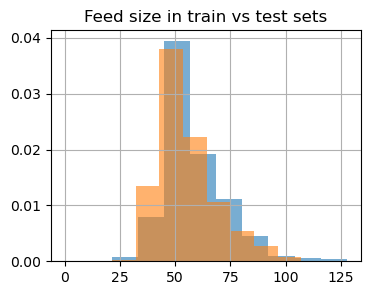

In [41]:
plt.figure(figsize=(4,3))
plt.title('Feed size in train vs test sets')

mask = 'rougher.input.feed_size'
features_train[mask][features_train[mask] <= features_train[mask].quantile(0.985)].hist(alpha=0.6, density=True)
features_test[mask][features_test[mask] <= features_test[mask].quantile(0.985)].hist(alpha=0.6, density=True)

Distributions are very similar. Both distributions are mostly normal, peaking at around 50 for both distributions, and are a bit right-skewed. We should be able to evaluate the model well. There are some much higher outliers which I omitted from the histogram by using the lower 98.5% of values.

## Total concentrations

I need to investigate the total concentrations of concentrate at each stage of the process - raw feed, rougher concentrate, and final concentrate - and potentially remove abnormal values. Some number of the abnormal values that would have been revealed in this phase may have already been eliminated when I dropped a few thousand observations above, but this will help eliminate more abnormal observations from the datasets.

Let's sum the concentrations at each stage and plot histograms for each stage for the training set.

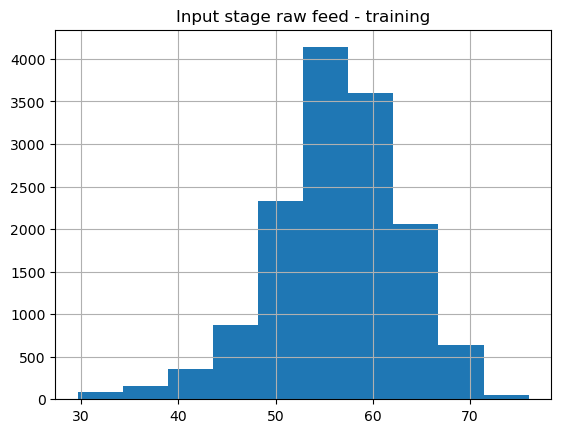

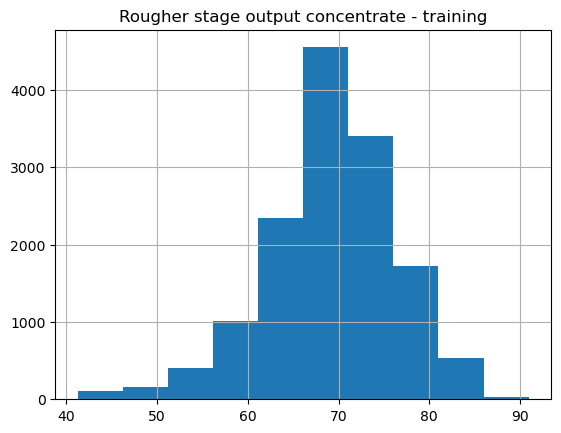

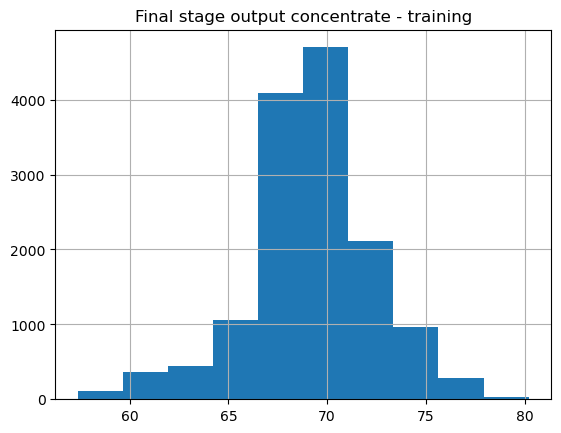

In [42]:
input_conc_sums = conc_train['rougher.input.feed_au'] + conc_train['rougher.input.feed_ag'] + conc_train['rougher.input.feed_pb'] + \
    conc_train['rougher.input.feed_sol']
input_drop_indexes = input_conc_sums[input_conc_sums < input_conc_sums.quantile(0.015)].index
input_conc_sums[input_conc_sums > input_conc_sums.quantile(0.015)].hist()
plt.title('Input stage raw feed - training')
plt.show()

rougher_conc_sums = conc_train['rougher.output.concentrate_au'] + conc_train['rougher.output.concentrate_ag'] + \
    conc_train['rougher.output.concentrate_pb'] + conc_train['rougher.output.concentrate_sol']
rougher_drop_indexes = [rougher_conc_sums < rougher_conc_sums.quantile(0.015)].index
rougher_conc_sums[rougher_conc_sums > rougher_conc_sums.quantile(0.015)].hist()
plt.title('Rougher stage output concentrate - training')
plt.show()

final_conc_sums = conc_train['final.output.concentrate_au'] + conc_train['final.output.concentrate_ag'] + \
    conc_train['final.output.concentrate_pb'] + conc_train['final.output.concentrate_sol']
final_drop_indexes = [final_conc_sums < final_conc_sums.quantile(0.025)].index
final_conc_sums[final_conc_sums > final_conc_sums.quantile(0.025)].hist()
plt.title('Final stage output concentrate - training')
plt.show()

I have omitted outliers from each histogram with as conservative a cutoff as possible to achieve greater normality. I will drop the outlier values from the training and testing sets using these quantile values.

In [43]:
features_train, target_train, conc_train = trim_rows(
    features_train, target_train, conc_train, condition='n', indexes=input_drop_indexes)

Length of original dataframes: 14494
Length of trimmed dataframes: 14276


In [44]:
features_train, target_train, conc_train = trim_rows(
    features_train, target_train, conc_train, condition='n', indexes=rougher_drop_indexes)

Length of original dataframes: 14276
Length of trimmed dataframes: 14276


In [45]:
features_train, target_train, conc_train = trim_rows(
    features_train, target_train, conc_train, condition='n', indexes=final_drop_indexes)

Length of original dataframes: 14276
Length of trimmed dataframes: 14276


Let's move onto the testing set.

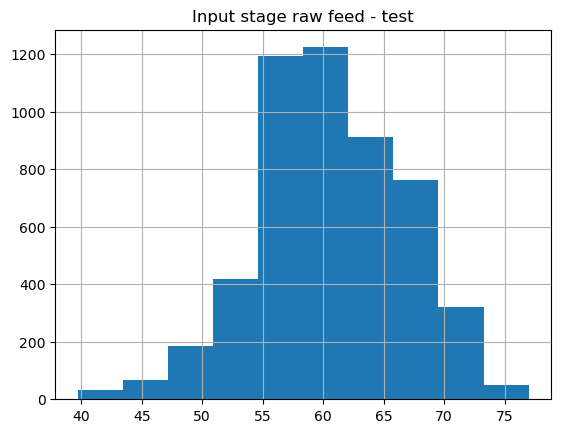

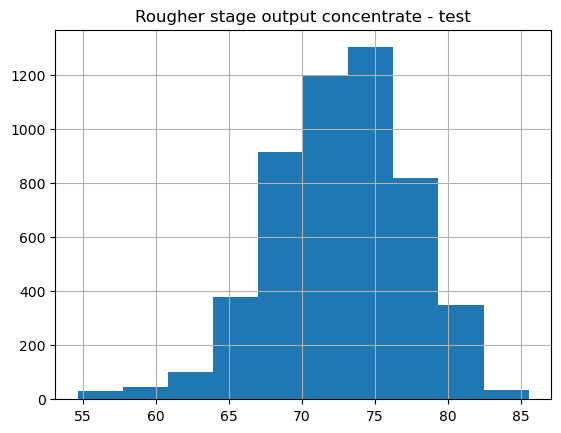

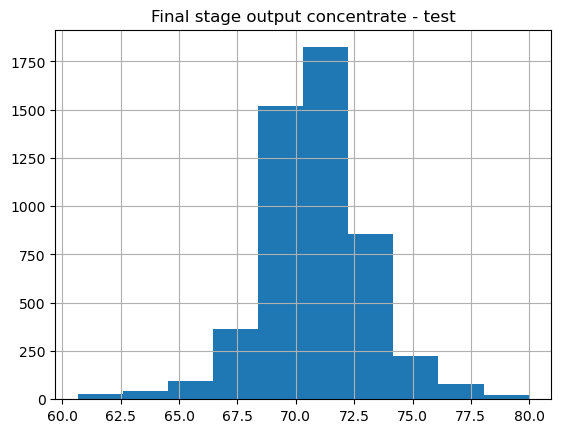

In [46]:
input_conc_sums = conc_test['rougher.input.feed_au'] + conc_test['rougher.input.feed_ag'] + conc_test['rougher.input.feed_pb'] + \
    conc_test['rougher.input.feed_sol']
input_drop_indexes = input_conc_sums[input_conc_sums < input_conc_sums.quantile(0.015)].index
input_conc_sums[input_conc_sums > input_conc_sums.quantile(0.02)].hist()
plt.title('Input stage raw feed - test')
plt.show()

rougher_conc_sums = conc_test['rougher.output.concentrate_au'] + conc_test['rougher.output.concentrate_ag'] + \
    conc_test['rougher.output.concentrate_pb'] + conc_test['rougher.output.concentrate_sol']
rougher_drop_indexes = [rougher_conc_sums < rougher_conc_sums.quantile(0.015)].index
rougher_conc_sums[rougher_conc_sums > rougher_conc_sums.quantile(0.02)].hist()
plt.title('Rougher stage output concentrate - test')
plt.show()

final_conc_sums = conc_test['final.output.concentrate_au'] + conc_test['final.output.concentrate_ag'] + \
    conc_test['final.output.concentrate_pb'] + conc_test['final.output.concentrate_sol']
final_drop_indexes = [final_conc_sums < final_conc_sums.quantile(0.025)].index
final_conc_sums[final_conc_sums > final_conc_sums.quantile(0.04)].hist()
plt.title('Final stage output concentrate - test')
plt.show()

In [47]:
features_test, target_test, conc_test = trim_rows(
    features_test, target_test, conc_test, condition='n', indexes=input_drop_indexes)

Length of original dataframes: 5270
Length of trimmed dataframes: 5190


In [48]:
features_test, target_test, conc_test = trim_rows(
    features_test, target_test, conc_test, condition='n', indexes=rougher_drop_indexes)

Length of original dataframes: 5190
Length of trimmed dataframes: 5190


In [49]:
features_test, target_test, conc_test = trim_rows(
    features_test, target_test, conc_test, condition='n', indexes=final_drop_indexes)

Length of original dataframes: 5190
Length of trimmed dataframes: 5190


Outliers here have been removed.

## Complete preprocessing

Now that all other preprocessing steps have been completed and training/testing dataframes have been finalized, I will reset the indexes.

In [50]:
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

# Build Models

Time to build the regression the models. I will try out a linear regression model and a random forest regressor model, and score them using cross-validation. I'll evaluate performance based on symmetric mean absolute percent error (sMAPE), select the model with the highest score, and test it on the test set to yield a final sMAPE score. 

## Calculate sMAPE

Writing functions to calculate sMAPE and to combine the rougher and final sMAPE scores into a final score.

In [51]:
def calc_smape(actual, pred):
    
    """
    This function takes a series of answers and of predictions, and calculates symmetric mean absolute percentage error (sMAPE).
        It returns the sMAPE value.
    """
    
    N = len(actual)
    sum = 0
    for i in range(N):
        numerator = abs(actual[i] - pred[i]) * 100
        denominator = (abs(actual[i]) + abs(pred[i])) / 2
        sum += (numerator/denominator)
    smape = sum / N
    
    return smape

In [52]:
def combine_smapes(rougher, final):
    
    """
    Calculates a combined sMAPE score using the rougher concentrate sMAPE and final concentrate sMAPE score as inputs.
    """
    
    return (0.25 * rougher) + (0.75 * final)

## Train/evaluate the models

Normally I would use the cross-validation function offered by sklearn, but due to having several targets and a different type of score, I will need to use a more customizable version. Cross-validation will allow me to select the model with the lower sMAPE score. At that point I will train that model type on the entirety of the training data and then test it on the test set for a final tested sMAPE score. 

In [54]:
def cross_val(features, targets, model_type, sets=5, n_estimators=10, max_depth=5):

    """ 
    This function cross-validates regression models, calculates sMAPE using a separate function, and prints the average combined
        sMAPE score.
    
    The features and targets dataframes are the first inputs, followed by 'LR' or 'RF' to train linear regression or random forest
        regression models, respectively. The function, by default, uses five rotating sets for cross-validation, but this value 
        can be changed.
    """
    
    scores = []
    sample_size = int(len(features)/sets)
    
    k = 0 # Create counter to count the number of for-loop iterations
    
    for i in range(0, len(features), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0, i)) + list(range(i + sample_size, len(features)))

#         Split variables features and target into samples features_train, target_train, features_valid, target_valid
        features_train = features.iloc[train_indexes].reset_index(drop=True)
#         display(features_train)
        features_valid = features.iloc[valid_indexes].reset_index(drop=True)
#         display(features_valid)
        target_train = targets.iloc[train_indexes].reset_index(drop=True)
        target_valid = targets.iloc[valid_indexes].reset_index(drop=True)

#         Build model and store predictions based on model type chosen
        if model_type == 'LR':
            model = LinearRegression()
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))
        if model_type == 'RF':
            model = RandomForestRegressor(max_features=1.0, n_estimators=n_estimators, max_depth=max_depth, random_state=0)
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))

#         Store answers and specific predictions
        rougher_recov_actual = target_valid['rougher.output.recovery']
        final_recov_actual = target_valid['final.output.recovery']
        rougher_recov_pred = pred.iloc[:,0]
        final_recov_pred = pred.iloc[:,1]    

#         Calculate sMAPE
        rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
        final_smape = calc_smape(final_recov_actual, final_recov_pred)
        combined_smape = combine_smapes(rougher_smape, final_smape)
    
        scores.append(combined_smape)
        
#         Break loop when number of desired sets is reached
        k += 1
        if k == sets:
            break
            
    final_score = round(pd.Series(scores).mean(), 2)
    print(f'Average model symmetric mean percent error: {final_score}%')

Let's use this function to find the average combined sMAPE for a linear regression model.

In [56]:
%%time
cross_val(features_train, target_train, 'LR')

Average model symmetric mean percent error: 7.4%
CPU times: total: 20.1 s
Wall time: 12 s


And now for the random forest regression model. I will first loop through max_depth values with a low, constant n_estimators value and then choose the max_depth that yields the lowest sMAPE. If the sMAPE for multiple options are very close, I may choose hyperparameters that require less processing power/runtime. After that I will loop through some n_estimators values with the constant max_depth that performed best in the first loop. Breaking this process into two independent loops should cut down on overall runtime.

In [ ]:
for depth in range(15,21,1):
    print(f'max_depth: {depth}')
    cross_val(features_train, target_train, 'RF', n_estimators=20, max_depth=depth, sets=4)

I don't want to risk overfitting the model, so I don't want to continue trying max_depths past 20. The gains in performance as the max_depth approaches 20 are small. I will choose 20 as my preferred max_depth.

In [ ]:
for n_est in range(40,81,10):
    print(f'n_estimators: {n_est}')
    cross_val(features_train, target_train, 'RF', n_estimators=n_est, max_depth=20, sets=4)

As with the search for the optimal max_depth above, the performance gained by additional trees seems to flatten off. I will use 80 trees as my n_estimators value, along with the max_depth of 20 from above.

The random forest regression model has a distinctly lower sMAPE than that for linear regression, at 4.95%, so I will use that model type. I will train the random forest regression model on the complete training set, then find the sMAPE on the test set.

In [ ]:
model_forest = RandomForestRegressor(max_features=1.0, n_estimators=80, max_depth=20, random_state=0)
model_forest.fit(features_train, target_train)
pred = pd.DataFrame(model_forest.predict(features_test))

rougher_recov_actual = target_test['rougher.output.recovery']
final_recov_actual = target_test['final.output.recovery']
rougher_recov_pred = pred.iloc[:,0]
final_recov_pred = pred.iloc[:,1]      
        
#         Calculate sMAPE
rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
final_smape = calc_smape(final_recov_actual, final_recov_pred)
combined_smape = combine_smapes(rougher_smape, final_smape)

print(f'Combined sMAPE: {round(combined_smape, 2)}%')

The tested combined sMAPE is somewhat higher than it was for the cross-validated set, but it is still below 10%, which seems acceptable, as Zyfra did not list any requirements for maximum tested sMAPE allowed in a working model. The random forest model does take longer to train than the linear regression model did, but the runtime itself is not egregious.

Let's determine the sMAPE for a dummy model and compare that error with our tested error and our cross-validated error.

In [ ]:
for strategy in ['mean', 'median']:    
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(features_train, target_train)
    pred = pd.DataFrame(dummy_regr.predict(features_test))

    rougher_recov_actual = target_test['rougher.output.recovery']
    final_recov_actual = target_test['final.output.recovery']
    rougher_recov_pred = pred.iloc[:,0]
    final_recov_pred = pred.iloc[:,1]      

    #         Calculate sMAPE
    rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
    final_smape = calc_smape(final_recov_actual, final_recov_pred)
    combined_smape = combine_smapes(rougher_smape, final_smape)

    print(f'Combined sMAPE with {strategy}: {round(combined_smape, 2)}%')

The tested sMAPE of 7.53% is slightly lower than the dummy sMAPE of 7.67% when using the mean, but slightly higher than the dummy sMAPE of 7.23% when using the median. The cross-validated sMAPE of 4.95% is distinctly lower than either dummy error. Therefore, the model seems to perform around or better than simply predicting using the mean or median as predictions.

In [ ]:
# Save the model to a joblib file for further use
dump(model_forest, 'ZyfraGoldRecoveryPredictor.joblib')

# Conclusion

I received three datasets from Zyfra - one full dataset, and training and test sets already split up for me. The test set contained only features that would be available to the company at the beginning of the extraction process, so I had to revise the training set to reflect only those features. The aim was to build a model to predict gold concentrate recovery at the rougher stage and at the final stage of extraction, using symmetric mean absolute percent error for both recoveries and finding a weighted average of them. The recovery included with the data needed to make sense, so I calculated the recovery using a given equation, which matched the recovery in the dataset. I looked at the concentrations of metals at each stage of the process, and filtered out observations that made no sense. I evaluated the distributions of feed size in the training and test sets to make sure they were similar. Beyond that, I dropped missing values after trimming my training and testing datasets to preserve as many observations as possible.

I cross-validated linear regression and random forest regression models, finding that the random forest model had lower error, with a sMAPE of 4.95%. I trained this model with the same hyperparameters on the full training set and tested it, yielding a 7.53% sMAPE. Zyfra provided no requirements for sMAPE, but the model was compared with a dummy model with mean/median predictions, and the tested model performed slightly worse than the dummy model using the median. However, the cross-validated sMAPE on the model was distrinctly less than the sMAPE for either dummy model, demonstrating the model should perform at around the same level as or better than a dummy model. I saved the random forest model to a .joblib file for further use by the company.